In [1]:
import numpy as np
from scipy.integrate import quad, odeint, solve_ivp
from scipy.special import kn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker

import pickle

import math
from numpy import cos, sin, pi

import lib.config as config

from importlib import reload

import lib.utils
import lib.Xsecs
import lib.cosmo_def

#%matplotlib inline
font = {'family':'serif', 'serif': ['computer modern roman']}
plt.rc('font',**font)
plt.rcParams['text.usetex'] = True

def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

In [30]:
mN_val = 10 # MeV

coupling_O = -1

prefix_loc = '/Users/Tae/Desktop/N_effective/Type_I_variant/main_code_v2/data_m_scan'
plot_loc = '/Users/Tae/Desktop/N_effective/Type_I_variant/main_code_v2/data_m_scan/plots'

#'''
inputs = pd.read_csv(f'./data_m_scan/mN{mN_val}_1e{int(coupling_O)}/input_variables_mN_{mN_val}.csv')

Ty_df = pd.read_csv(f'./data_m_scan/mN{mN_val}_1e{int(coupling_O)}/photon_Temperatures_mN_{mN_val}.csv')
Tnu_e_df = pd.read_csv(f'./data_m_scan/mN{mN_val}_1e{int(coupling_O)}/nu_e_Temperatures_mN_{mN_val}.csv')
Tnu_mu_df = pd.read_csv(f'./data_m_scan/mN{mN_val}_1e{int(coupling_O)}/nu_mu_Temperatures_mN_{mN_val}.csv')
Tchi_df = pd.read_csv(f'./data_m_scan/mN{mN_val}_1e{int(coupling_O)}/chi_Temperatures_mN_{mN_val}.csv')


inputs = inputs[np.array([(Ty_df.loc[99,:] > 1e-5)]).T]

Tnu_e_df = Tnu_e_df.T[np.array((Ty_df.loc[99:] > 1e-5))[0].T].T    # .T[np.array([(Ty_df.loc[99,:] > 1e-5)]).T].T
Tnu_mu_df = Tnu_mu_df.T[np.array((Ty_df.loc[99:] > 1e-5))[0].T].T  # .T[np.array([(Ty_df.loc[99:] > 1e-5)]).T].T
Tchi_df = Tchi_df.T[np.array((Ty_df.loc[99:] > 1e-5))[0].T].T   # .T[np.array([(Ty_df.loc[99,:] > 1e-5)]).T].T
Ty_df = Ty_df.T[Ty_df.loc[99,:] > 1e-5].T


time = np.logspace(np.log10(8e-3), np.log10(5e10), 600)

MeV_to_invsec = config.MeV_to_invsec


fixed_Lnu = 2.15e-8
fixed_m_phi = 1e-2 # MeV

thresholdcut = 2e-2

axisfontsize = 16
intextsize = 13
ticksize = 13

ref_inputs = inputs[(np.abs(np.log10(inputs['M_nu']/fixed_Lnu)).round(1)<=thresholdcut)&(inputs['M_phi'] == fixed_m_phi)]


ref_Ty_df = pd.DataFrame(Ty_df.to_numpy().T[((np.abs(np.log10(inputs['M_nu']/fixed_Lnu)).round(1)<=thresholdcut) 
                                             & (inputs['M_phi'] == fixed_m_phi)).to_numpy()].T)
ref_Tnu_e_df = pd.DataFrame(Tnu_e_df.to_numpy().T[((np.abs(np.log10(inputs['M_nu']/fixed_Lnu)).round(1)<=thresholdcut) 
                                             & (inputs['M_phi'] == fixed_m_phi)).to_numpy()].T)
ref_Tnu_mu_df = pd.DataFrame(Tnu_mu_df.to_numpy().T[((np.abs(np.log10(inputs['M_nu']/fixed_Lnu)).round(1)<=thresholdcut) 
                                             & (inputs['M_phi'] == fixed_m_phi)).to_numpy()].T)
ref_Tchi_df = pd.DataFrame(Tchi_df.to_numpy().T[((np.abs(np.log10(inputs['M_nu']/fixed_Lnu)).round(1)<=thresholdcut) 
                                             & (inputs['M_phi'] == fixed_m_phi)).to_numpy()].T)

part_evnts = len(inputs[((np.abs(np.log10(inputs['M_nu']/fixed_Lnu)).round(1)<=thresholdcut) 
                         & (inputs['M_phi'] == fixed_m_phi)).to_numpy()].T)



##############################
### Assign input variables ###
##############################

config.config_params['Lnu'] = 1e-1
config.config_params['Lchi'] = 3e-3
config.config_params['chi_flav'] = 1

config.config_params['m_nl1'] = fixed_Lnu
config.config_params['m_nl2'] = fixed_Lnu
config.config_params['m_nl3'] = fixed_Lnu

config.config_params['mN1'] = mN_val
config.config_params['mN2'] = mN_val
config.config_params['mN3'] = mN_val

config.config_params['Mass_phi'] = fixed_m_phi
config.config_params['Mass_chi'] = 1e-9


Lnu = config.config_params['Lnu']
Lchi = config.config_params['Lchi']

m_nl1 = config.config_params['m_nl1']
m_nl2 = config.config_params['m_nl2']
m_nl3 = config.config_params['m_nl3']

mN1 = config.config_params['mN1']
mN2 = config.config_params['mN2']
mN3 = config.config_params['mN3']

Mass_phi = config.config_params['Mass_phi']
Mass_chi = config.config_params['Mass_chi']

chi_flav = config.config_params['chi_flav']


reload(lib.utils)
reload(lib.Xsecs)
reload(lib.cosmo_def)

from lib.utils import *
from lib.Xsecs import *
from lib.cosmo_def import *

# Decay width of phi
phi_decayW = decayWidth_phi(chi_flav, Lchi, Mass_phi)

# G_eff of chi SI
Geffchi = Geffchi(Lchi, Mass_phi)

# Neff Definition
def Neff_nu(Ty, Tnu_e, Tnu_mu):
    return 8/7*(11/4)**(4/3)* (rho_nu(Tnu_e) + 2*rho_nu(Tnu_mu))/rho_y(Ty)

def Neff(Ty, Tnu_e, Tnu_mu, Tchi):
    return 8/7*(11/4)**(4/3)* (rho_nu(Tnu_e) + 2*rho_nu(Tnu_mu) + rho_chi(Tchi, chi_flav))/rho_y(Ty)

3.0415344951097065 2.281146112896764 

0.75



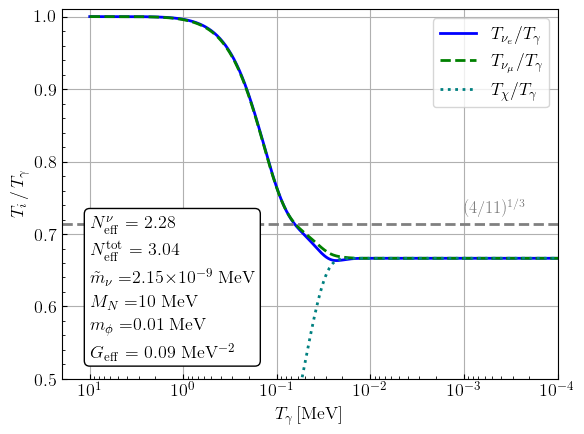

In [31]:
Ty_evnt = ref_Ty_df.to_numpy().flatten()
Tnu_e_evnt = ref_Tnu_e_df.to_numpy().flatten()
Tnu_mu_evnt = ref_Tnu_mu_df.to_numpy().flatten()
Tchi_evnt = ref_Tchi_df.to_numpy().flatten()

N_eff_tot = Neff(Ty_evnt[-1],
                 Tnu_e_evnt[-1], 
                 Tnu_mu_evnt[-1],
                 Tchi_evnt[-1])
    
N_eff_nu = Neff_nu(Ty_evnt[-1],
                   Tnu_e_evnt[-1], 
                   Tnu_mu_evnt[-1])

print(N_eff_tot,N_eff_nu,'\n')
print(f"{N_eff_nu/N_eff_tot:0.3}\n")

plt.plot(Ty_evnt, Tnu_e_evnt/Ty_evnt, 'b', label=r'$T_{\nu_e}/T_{\gamma}$', lw = 2)
plt.plot(Ty_evnt, Tnu_mu_evnt/Ty_evnt, 'g',ls='dashed', label=r'$T_{\nu_{\mu}}/T_{\gamma}$', lw = 2)
plt.plot(Ty_evnt, Tchi_evnt/Ty_evnt, 'teal', ls='dotted', label=r'$T_{\chi}/T_{\gamma}$', lw = 2)

plt.axhline((4/11)**(1/3), c='gray', ls = 'dashed', lw = 2)
plt.annotate('$(4/11)^{1/3}$',(1e-3,0.73), fontsize=12, color=adjust_lightness('gray',1))

plt.xlim(1e-4,2e1)

plt.legend(loc='best', fontsize=13)
plt.xscale('log')
plt.gca().invert_xaxis()

plt.xlabel(r'$T_{\gamma}\,$[MeV]', fontsize=13)
plt.ylabel(r'$T_{i}\,/\,T_{\gamma}$', fontsize=13)
plt.tick_params(axis='both', direction="in", which='both', labelsize=13)

plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())

plt.text(1e1, 0.53, 
         r"$N_{\rm eff}^{\nu}$ = "+f"{N_eff_nu:.3}"
         +"\n"+r"$N_{\rm eff}^{\rm tot}$ = "+f"{N_eff_tot:.3}"
         +"\n"+r"$\tilde{m}_{\nu} = $"+f"{Lnu*n_light_phi('1', '1')*mN1*1e9:.3}"+"$\\times 10^{-9}$ MeV"
         +"\n"+r"$M_{N} = $"+f"{mN1} MeV"
         +"\n"+r"$m_{\phi} = $"+f"{Mass_phi:.3} MeV"
         +"\n"+r"$G_\mathrm{eff}$ = "+f"{Geffchi:.2}"+" MeV$^{-2}$",
         #+"\n"+r"$N^{\nu}_\mathrm{eff}$ = "+f"{N_eff_nu:.4}"
         #+"\n"+r"$N^\mathrm{tot}_\mathrm{eff}$ = "+f"{N_eff_tot:.4}", 
         color='black', fontsize=13, linespacing = 1.6, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

plt.ylim(0.5,1.01)

plt.grid()

#plt.savefig(plotting_loc+f"/Temperature_evolution_mN{mNval}.pdf",bbox_inches = 'tight')
#plt.savefig(f"./samp_Temperature_evolution_mN{mNval}.pdf",bbox_inches = 'tight')

In [32]:
# Interaction Rate calculation
def Gamma_T(Temp, flav1 = 'e', flav2 = 'e'):
    flav_list = np.array(['e','mu','ta'])
    fl1 = np.where(np.char.find(flav_list,flav1)==0)[0][0]
    fl2 = np.where(np.char.find(flav_list,flav2)==0)[0][0]

    ma = mass_nlight[0,0].real

    intval = 0
    stepsize = 0.1
    initG = np.log10(4*ma**2).round()
    finG = 5
    for seg in np.arange(initG,finG+1,stepsize):
        temp, err = quad(lambda s: 
                         Xsec_flav(s, Lnu, chi_flav, Lchi, Mass_phi, flav1, flav2)*(s-4*ma**2)*np.sqrt(s)*kn(1, np.sqrt(s)/Temp),
                         10**seg,
                         10**(seg+stepsize),
                         epsabs=10**-10,epsrel=10**-10)
        intval += temp
    
    
    prefactor = 1/(8*ma**4*Temp*(kn(2, ma/Temp))**2)
    
    return 1.2/pi**2*3/4*Temp**3*prefactor*intval.real

def Gamma_T_nlnl(Temp):
    
    ma = mass_nlight[0,0].real

    intval = 0
    stepsize = 0.1
    initG = np.log10(4*ma**2).round()
    finG = 5
    for seg in np.arange(initG,finG+1,stepsize):
        temp, err = quad(lambda s: 
                         Xsec_nlnl(s, m_nl1, m_nl1)*(s-4*ma**2)*np.sqrt(s)*kn(1, np.sqrt(s)/Temp),
                         10**seg,
                         10**(seg+stepsize),
                         epsabs=10**-10,epsrel=10**-10)
        intval += temp
    
    prefactor = 1/(8*ma**4*Temp*(kn(2, ma/Temp))**2)
    
    return 1.2/pi**2*3/4*Temp**3*prefactor*intval.real

def Gamma_T_nlFC(Temp): # flavor change
    
    ma = mass_nlight[0,0].real

    intval = 0
    stepsize = 0.1
    initG = np.log10(4*ma**2).round()
    finG = 5
    for seg in np.arange(initG,finG+1,stepsize):
        temp, err = quad(lambda s: 
                         Xsec_nlnl(s,m_nl1,m_nl2)*(s-4*ma**2)*np.sqrt(s)*kn(1, np.sqrt(s)/Temp),
                         10**seg,
                         10**(seg+stepsize),
                         epsabs=10**-10,epsrel=10**-10)
        intval += temp
    
    prefactor = 1/(8*ma**4*Temp*(kn(2, ma/Temp))**2)
    
    return 1.2/pi**2*3/4*Temp**3*prefactor*intval.real


def Gamma_T_nlphi(Temp):
    
    ma = Mass_phi

    intval = 0
    stepsize = 0.1
    initG = np.log10(4*Mass_phi**2).round()
    finG = 5
    for seg in np.arange(initG,finG+1,stepsize):
        temp, err = quad(lambda s: 
                         Xsec_viphi(s, Lnu, Mass_phi, m_nl1, mN1, mN2, mN3)*(s-4*ma**2)*np.sqrt(s)*kn(1, np.sqrt(s)/Temp),
                         10**seg,
                         10**(seg+stepsize),
                         epsabs=10**-10,epsrel=10**-10)
        intval += temp
    
    if intval*(8*ma**4*Temp*(kn(2, ma/Temp))**2)==0:
        return 0
        
    else:
        prefactor = 1/(8*ma**4*Temp*(kn(2, ma/Temp))**2)
        
        return rho_phi(Temp,Mass_phi)/Mass_phi*prefactor*intval.real


def Gamma_T_chiSI(Temp):
    
    ma = Mass_chi

    intval = 0
    stepsize = 0.05
    initG = np.log10(4*ma**2).round()
    finG = 0
    for seg in np.arange(initG,finG+1,stepsize):
        temp, err = quad(lambda s: 
                         Xsec_chiSI(s, Lchi, Mass_phi, chi_flav)*(s-4*ma**2)*np.sqrt(s)*kn(1, np.sqrt(s)/Temp),
                         10**seg,
                         10**(seg+stepsize),
                         epsabs=10**-10,epsrel=10**-10)
        intval += temp
    
    prefactor = 1/(8*ma**4*Temp*(kn(2, ma/Temp))**2)
    
    return 1.2/pi**2*3/4*Temp**3*prefactor*intval.real

In [20]:
# Rate to Hubble Ratio calculation
Gam_over_H = []
Gam_nlnl_over_H = []
Gam_nlFC_over_H = []
Gam_nlphi_over_H = []


for ii in range(len(Ty_evnt)):
    interaction_rate = MeV_to_invsec*Gamma_T(Tnu_e_evnt[ii],flav1 = 'e', flav2 = 'e')
    interaction_rate_nl = MeV_to_invsec*Gamma_T_nlnl(Tnu_e_evnt[ii])
    #interaction_rate_nlFC = MeV_to_invsec*Gamma_T_nlFC(Tnu_e_evnt[ii])
    interaction_rate_nlphi = MeV_to_invsec*Gamma_T_nlphi(Tnu_e_evnt[ii])
    
    hubble = Hubble(Ty_evnt[ii], Tnu_e_evnt[ii], Tnu_mu_evnt[ii], Tchi_evnt[ii], chi_flav, Mass_phi)
    
    Gam_over_H.append(interaction_rate/hubble)
    Gam_nlnl_over_H.append(interaction_rate_nl/hubble)
    #Gam_nlFC_over_H.append(interaction_rate_nlFC/hubble)
    Gam_nlphi_over_H.append(interaction_rate_nlphi/hubble)
    
    if (ii+1)%100==0:
        print(ii)

Gam_over_H = np.array(Gam_over_H)
Gam_nlnl_over_H = np.array(Gam_nlnl_over_H)
#Gam_nlFC_over_H = np.array(Gam_nlFC_over_H)
Gam_nlphi_over_H = np.array(Gam_nlphi_over_H)

99
199
299
399
499
599


1.00e-02  MeV 



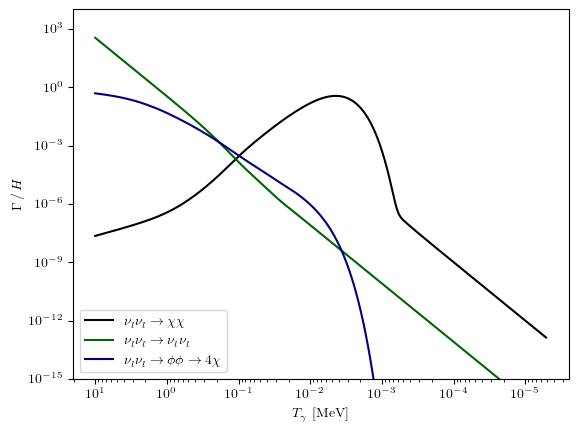

In [21]:
print(f"{Mass_phi:.2e}"," MeV","\n")

plt.plot(Ty_evnt, Gam_over_H, 'black',label=r'$\nu_l\nu_l\to\chi\chi$')
plt.plot(Ty_evnt, Gam_nlnl_over_H, 'darkgreen',label=r'$\nu_l\nu_l\to\nu_l\nu_l$')
#plt.plot(Ty_evnt, Gam_nlFC_over_H, 'darkorange',label=r'$\nu_l\nu_l\to\nu_l\,\prime\,\nu_l\,\prime$')
plt.plot(Ty_evnt, Gam_nlphi_over_H, 'navy',label=r'$\nu_l\nu_l\to\phi\phi\to 4\chi$')

plt.gca().invert_xaxis()

plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left')
plt.ylim(10**-15,10**4)
plt.ylabel(r'$\Gamma \, /\, H$')
plt.xlabel(r'$T_\gamma$ [MeV]')
#plt.savefig(plotting_loc+f"/Rate_to_Hubble_nunu2XX_{mNval}.pdf",
#            bbox_inches = 'tight')
plt.show()

In [22]:
Gam_chiSI_over_H = []

for ii in range(len(Ty_evnt)):
    interaction_rate_chiSI = MeV_to_invsec*Gamma_T_chiSI(Tchi_evnt[ii])
    hubble = Hubble(Ty_evnt[ii], Tnu_e_evnt[ii], Tnu_mu_evnt[ii], Tchi_evnt[ii], chi_flav, Mass_phi)

    Gam_chiSI_over_H.append(interaction_rate_chiSI/hubble)
    
    if (ii+1)%100==0:
        print(ii)

Gam_chiSI_over_H = np.array(Gam_chiSI_over_H)

99
199
299
399
499
599


Text(0.5, 0, '$T_\\gamma$ [MeV]')

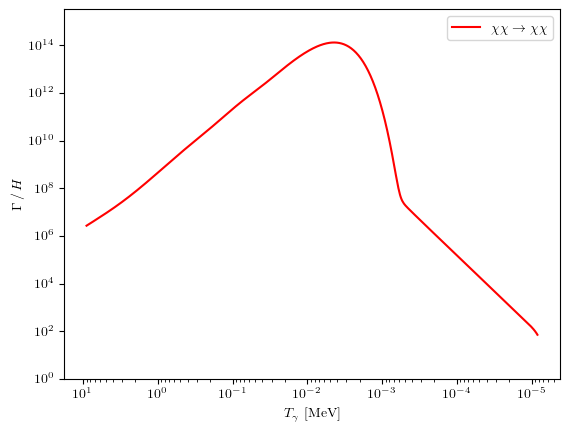

In [23]:
plt.plot(Ty_evnt[4:-20], Gam_chiSI_over_H[4:-20], 'red',label=r'$\chi\chi\to\chi\chi$')
#Textnd=np.logspace(-7,-3,5)
#plt.plot(Textnd, 10**19.6*(Textnd)**3, 'grey',linestyle="dashed",label=r'Extend')
plt.gca().invert_xaxis()

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylim(10**0,10**15.5)
plt.ylabel(r'$\Gamma \, /\, H$')
plt.xlabel(r'$T_\gamma$ [MeV]')
#plt.savefig(plotting_loc+"/Rate_to_Hubble_chiSI_0.pdf",
#            bbox_inches = 'tight')


1.00e-02  MeV 



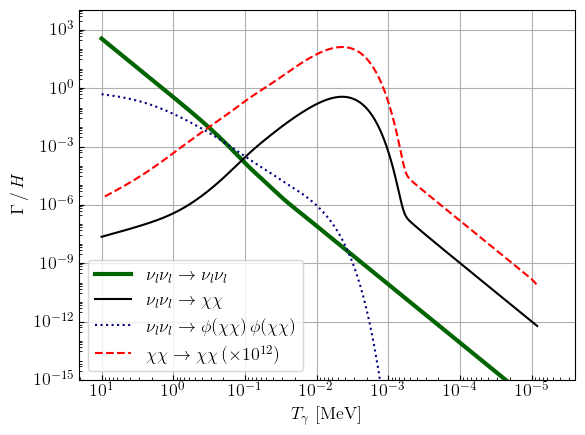

In [24]:
print(f"{Mass_phi:.2e}"," MeV","\n")

plt.plot(Ty_evnt, Gam_nlnl_over_H, 'darkgreen',label=r'$\nu_l\nu_l\to\nu_l\nu_l$', lw = 3)

plt.plot(Ty_evnt[:-20], Gam_over_H[:-20], 'black',label=r'$\nu_l\nu_l\to\chi\chi$')
#plt.plot(Ty_evnt, Gam_nlFC_over_H, 'darkorange',label=r'$\nu_l\nu_l\to\nu_l\,\prime\,\nu_l\,\prime$')
plt.plot(Ty_evnt, Gam_nlphi_over_H, 'navy',label=r'$\nu_l\nu_l\to\phi(\chi\chi)\,\phi(\chi\chi)$', ls = 'dotted')
plt.plot(Ty_evnt[4:-20], Gam_chiSI_over_H[4:-20]*1e-12, 'red',label=r'$\chi\chi\to\chi\chi\,(\times 10^{12})$',ls = 'dashed')

plt.gca().invert_xaxis()

plt.yscale('log')
plt.xscale('log')

plt.legend(loc='lower left', fontsize=13)
plt.ylim(10**-15,10**4)

plt.ylabel(r'$\Gamma \, /\, H$', fontsize=13)
plt.xlabel(r'$T_\gamma$ [MeV]', fontsize=13)

plt.gca().yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=7))  
plt.gca().yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1, 10, 2), numticks=20))

plt.tick_params(axis='both', direction="in", which="both", labelsize=13)

plt.tick_params(axis='y', direction="in", which="minor",labelsize = 0, labelcolor='w')

plt.grid()

#plt.savefig(plotting_loc+f"/Rate_to_Hubble_all_mN{mNval}.pdf",
#            bbox_inches = 'tight')
plt.show()

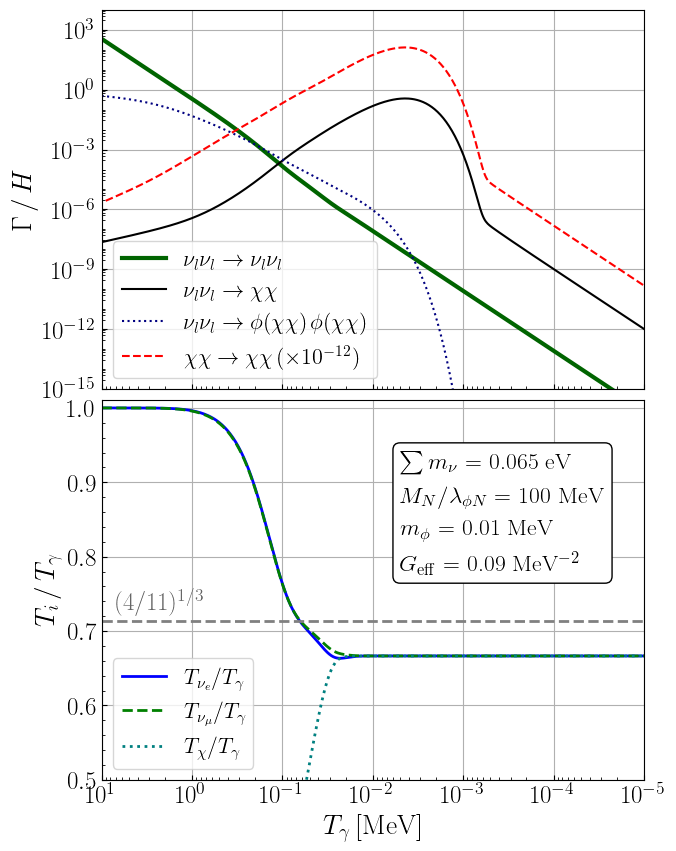

In [39]:
from matplotlib import gridspec

fontsize = 18
axissize = 20

fig = plt.figure(figsize = (7,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])

ax0 = plt.subplot(gs[0])

ax0.plot(Ty_evnt, Gam_nlnl_over_H, 'darkgreen',label=r'$\nu_l\nu_l\to\nu_l\nu_l$', lw = 3)

ax0.plot(Ty_evnt[:-20], Gam_over_H[:-20], 'black',label=r'$\nu_l\nu_l\to\chi\chi$')
ax0.plot(Ty_evnt, Gam_nlphi_over_H, 'navy',label=r'$\nu_l\nu_l\to\phi(\chi\chi)\,\phi(\chi\chi)$', ls = 'dotted')
ax0.plot(Ty_evnt[4:-20], Gam_chiSI_over_H[4:-20]*1e-12, 'red',label=r'$\chi\chi\to\chi\chi\,(\times 10^{-12})$',ls = 'dashed')

ax0.set_yscale('log')
ax0.set_xscale('log')

ax0.legend(loc='lower left', fontsize=16)
ax0.set_ylim(10**-15,10**4)

ax0.set_ylabel(r'$\Gamma \, /\, H$', fontsize=axissize)
#plt.xlabel(r'$T_\gamma$ [MeV]', fontsize=fontsize)

ax0.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=7))  
ax0.yaxis.set_minor_locator(ticker.LogLocator(base=10.0, subs=np.arange(1, 10, 2), numticks=20))

ax0.tick_params(axis='both', direction="in", which="both", labelsize=fontsize)

ax0.tick_params(axis='y', direction="in", which="minor",labelsize = 0, labelcolor='w')
ax0.grid()
plt.setp(ax0.get_xticklabels(), visible=False)

ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.plot(Ty_evnt, Tnu_e_evnt/Ty_evnt, 'b', label=r'$T_{\nu_e}/T_{\gamma}$', lw = 2)
ax1.plot(Ty_evnt, Tnu_mu_evnt/Ty_evnt, 'g',ls='dashed', label=r'$T_{\nu_{\mu}}/T_{\gamma}$', lw = 2)
ax1.plot(Ty_evnt, Tchi_evnt/Ty_evnt, 'teal', ls='dotted', label=r'$T_{\chi}/T_{\gamma}$', lw = 2)

ax1.axhline((4/11)**(1/3), c='gray', ls = 'dashed', lw = 2)
ax1.annotate('$(4/11)^{1/3}$',(7.0,0.73), fontsize=fontsize, color=adjust_lightness('gray',0.8))

ax1.legend(loc='best', fontsize=16)
ax1.set_xscale('log')


ax1.set_ylabel(r'$T_{i}\,/\,T_{\gamma}$', fontsize=axissize)
ax1.tick_params(axis='both', direction="in", which='both', labelsize=fontsize)

ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.text(5e-3, 0.78, 
         r"$\sum {m}_{\nu}$ = "+f"{3*n_light_phi('1', '1')*mN1*1e6:.2}"+" eV"
         +"\n"+r"$M_{N}/\lambda_{\phi N}$ = "+f"{mN1/Lnu :.3g} MeV"
         +"\n"+r"$m_{\phi}$ = "+f"{Mass_phi:.3} MeV"
         +"\n"+r"$G_\mathrm{eff}$ = "+f"{Geffchi:.2}"+" MeV$^{-2}$",
         #+"\n"+r"$N^{\nu}_\mathrm{eff}$ = "+f"{N_eff_nu:.4}"
         #+"\n"+r"$N^\mathrm{tot}_\mathrm{eff}$ = "+f"{N_eff_tot:.4}", 
         color='black', fontsize=17, linespacing = 1.6, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

ax1.grid()
ax1.set_ylim(0.5,1.01)

plt.xlabel(r'$T_{\gamma}\,$[MeV]', fontsize=axissize)
plt.xlim(1e-5,10)
plt.gca().invert_xaxis()
plt.subplots_adjust(hspace=.03)

plt.savefig(plot_loc+f"/Stacked_plot_mN{mN_val}.pdf",
            bbox_inches = 'tight')


In [34]:
print(r"$N^{\nu}_\mathrm{eff}$ = "+f"{N_eff_nu:.4}"
         +"\n"+r"$N^\mathrm{tot}_\mathrm{eff}$ = "+f"{N_eff_tot:.4}" ) 

$N^{\nu}_\mathrm{eff}$ = 2.281
$N^\mathrm{tot}_\mathrm{eff}$ = 3.042
